In [4]:
import pydicom
import matplotlib.pyplot as plt
# SOURCE SCRIPTS
#https://github.com/ReubenDo/ReMIND/

## DICOM analysis

In [221]:
def main(id=70):
    # Load the DICOM file

    t1contrast_pre_path = f'../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop-99162/1.000000-3DAXT1postcontrast-11531/1-0{id}.dcm'
    t1contrast_intra_path = f'../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Intraop-24150/6.000000-3DAXT1postcontrast-64739/1-0{id}.dcm'
    tumor_path = '../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop-99162/303.000000-tumor seg - MR ref 3DAXT1postcontrast-97101/1-1.dcm'
    t1_contrast_pre_dicom = pydicom.dcmread(t1contrast_pre_path)
    t1_contrast_intra_dicom = pydicom.dcmread(t1contrast_intra_path)
    tumor_dicom = pydicom.dcmread(tumor_path)
    return t1_contrast_pre_dicom, t1_contrast_intra_dicom, tumor_dicom

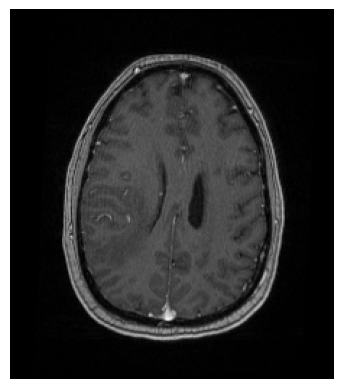

In [222]:
pre, post, tumor = main(63)
plt.imshow(tumor.pixel_array[:, :, 33], cmap='jet', alpha=0.9)  # Overlay the 'tumor' with transparency

plt.imshow(pre.pixel_array, cmap='gray')  # Display the grayscale 'pre' image

plt.axis('off')  # Remove axis
plt.show()  # Display both images

In [223]:
tumor.keys()

dict_keys([(0008,0005), (0008,0008), (0008,0016), (0008,0018), (0008,0020), (0008,0021), (0008,0023), (0008,0030), (0008,0031), (0008,0033), (0008,0050), (0008,0060), (0008,0070), (0008,0090), (0008,1030), (0008,103E), (0008,1090), (0010,0010), (0010,0020), (0010,0030), (0010,0040), (0012,0050), (0012,0060), (0012,0062), (0012,0063), (0012,0064), (0012,0071), (0013,0010), (0013,1010), (0013,1013), (0018,0015), (0018,1000), (0018,1020), (0020,000D), (0020,000E), (0020,0010), (0020,0011), (0020,0013), (0020,0052), (0020,1040), (0020,9221), (0020,9222), (0028,0002), (0028,0004), (0028,0008), (0028,0010), (0028,0011), (0028,0100), (0028,0101), (0028,0102), (0028,0103), (0028,0303), (0028,2110), (0062,0001), (0062,0002), (0062,0013), (0070,0080), (0070,0081), (0070,0084), (5200,9229), (5200,9230), (7FE0,0010)])

In [224]:
tumor

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 208
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.271595585736519184579299251692387669458
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008,0016) SOP Class UID                       UI: Segmentation Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.271595585736519184579299251692

In [225]:
pre.ImagePositionPatient
#pre['0020,0032']

[39.7105, -244.872, 57.4417]

In [226]:
pre

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 204
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.181935359382147226995987857515446051367
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'MPR']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.181935359382147226995987857515

### REMIND CONVERT BY https://github.com/ReubenDo/ReMIND/ is skipped, no tumor segmentations
### Using our own /scripts/preprocessing/remind/dcm2niix conversion, using dcm2niix and segimage2itkimage

In [48]:
import nibabel as nib
from nilearn.image import resample_to_img
pre_nifti  = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Intraop-24150/T1_converted/6.000000-3DAXT1postcontrast-64739_3D_AX_T1_postcontrast_19821225171237_6.nii.gz')
post_nifti = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop-99162/T1_converted/1.000000-3DAXT1postcontrast-11531_3D_AX_T1_postcontrast_19821225171232_1.nii.gz')
tumor_nifti = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop-99162/tumor_converted/1.nii.gz')

post_resample = resample_to_img(source_img=post_nifti, target_img=pre_nifti, interpolation='nearest')
tumor_resample = resample_to_img(source_img=tumor_nifti, target_img=pre_nifti, interpolation='nearest')

pre = pre_nifti.get_fdata()
post = post_resample.get_fdata()
tumor = tumor_resample.get_fdata()
print("pre ", pre_nifti.header)
print("\n post  ", post_resample.header)
print("\n ")
print("tumor " , tumor_resample.header)

pre  <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 176   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.         1.         1.1999973  0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=0;Time=0.000'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.24845804
quatern_c       : 0.9686003
quatern_d       : 0.009059608
qoffset_x       : 50.1

In [49]:
print(nib.aff2axcodes(pre_nifti.affine))
print(nib.aff2axcodes(post_resample.affine))
print(nib.aff2axcodes(tumor_resample.affine))


('L', 'A', 'S')
('L', 'A', 'S')
('L', 'A', 'S')


In [50]:
print(pre.shape, post.shape, tumor.shape)
print(pre_nifti.affine)
print(post_nifti.affine)
print(tumor_nifti.affine)

(256, 256, 176) (256, 256, 176) (256, 256, 176)
[[-8.76537025e-01  4.81312126e-01 -5.49262203e-03  5.01014099e+01]
 [ 4.81314003e-01  8.76373231e-01 -2.10370999e-02 -8.99381714e+01]
 [ 4.42653988e-03  1.75696034e-02  1.19980037e+00 -8.62670441e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 8.39540124e-01  4.89537895e-01  9.81967226e-02 -1.70631866e+02]
 [-4.92123127e-01  8.43494892e-01  2.49832356e-03  2.96257935e+01]
 [ 8.16189498e-02  5.04306480e-02 -9.94996965e-01  1.06282181e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-8.36110234e-01 -4.97573167e-01 -8.57658684e-02  3.29667044e+00]
 [ 4.98320371e-01 -8.39733958e-01  1.44071067e-02  1.14584480e+02]
 [-7.91891068e-02 -3.06929499e-02  9.96211171e-01  1.64463341e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


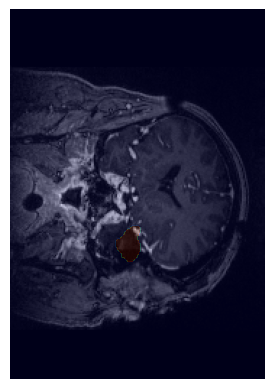

In [78]:
plt.imshow(pre[:, 150, :], cmap='gray', alpha=1)  # Overlay the 'tumor' with transparency
# plt.imshow(pre[140], cmap='jet', alpha=0.2)  # Display the grayscale 'pre' image
plt.imshow(tumor[:, 150, :], cmap='jet', alpha=0.2)  # Overlay the 'tumor' with transparency
plt.axis('off')  # Remove axis
plt.show()  # Display both images

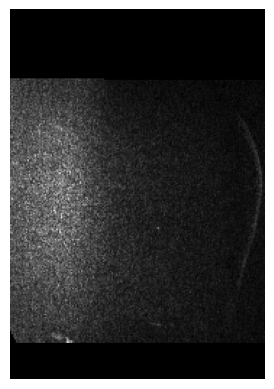

In [38]:
plt.imshow(pre[:, 12, :], cmap='gray', alpha=1)  # Overlay the 'tumor' with transparency
# plt.imshow(pre[30], cmap='gray')  # Display the grayscale 'pre' image
plt.axis('off')  # Remove axis
plt.show()  # Display both images

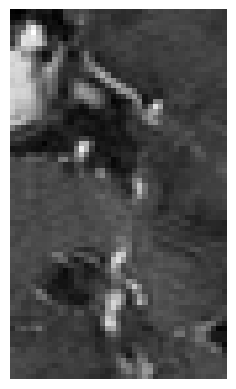

In [37]:
plt.imshow(tumor[0], cmap='gray', alpha=1)  # Overlay the 'tumor' with transparency
# plt.imshow(pre[30], cmap='gray')  # Display the grayscale 'pre' image
plt.axis('off')  # Remove axis
plt.show()  # Display both images